# Introduction

Following on the informative work of Nasir Khalid (see https://www.kaggle.com/nasirkhalid24/unsupervised-k-means-clustering-fake-news-87), this notebook is intended to use a Random Forest classifier to identify Fake News articles.

## Useful libraries

In [3]:
import numpy as np
import pandas as pd ##data processing, CSV I/O (e.g. pd.read_csv)
import string ## python library
import re ## regex library
import gensim.parsing.preprocessing as pp ## Preprocesssing functions from gensim
from gensim.models import Word2Vec # Word2vec

from sklearn.ensemble import RandomForestClassifier ##random forest classifier
from sklearn.model_selection import train_test_split ##split data into train and test sets
##Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.decomposition import PCA ##PCA for visualizing predictions and true labels
from sklearn.manifold import TSNE ##T-SNE for visualizing predictions and true labels

## Data Cleanup

In [4]:
fakeData = pd.read_csv(r'Fake.csv')  ##23481 articles labeled as fake
trueData = pd.read_csv(r'True.csv')  ##21417 articles labeled as true

As Nasir helpfully showed, many of the true articles contain identifiers -- such as '(Reuters)' or location names which do not appear in any of the fake articles.

In [8]:
trueData.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017"


In [9]:
fakeData.head(10)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017"
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017"
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017"
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017"
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017"


More specifically, many of the true articles (and <b>none</b> of the fake articles) contain:
<l>
    <li> The location followed by the publisher '(Reuters) - ' at the front.</li>
    <ul> <i> WASHINGTON (Reuters) - </i> </ul>
    <li> A disclaimer that the article is a tweet from President Trump. 
        <ul> <i> The following statements were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS. The opinions expressed are his own. Reuters has not edited the statements or confirmed their accuracy.  @realDonaldTrump : - </i></ul>
    </li>
    </l>
We need to remove these identifying features and consider the titles and text only.

In [11]:
cleanedData = []
for data in trueData.text:
    if '@realDonaldTrump : - ' in data:
        data = data.split('@realDonaldTrump : - ')[1]
    if '(Reuters) - ' in data:
        data = data.split('(Reuters) - ')[1]
    cleanedData.append(data)
trueData.text = cleanedData
trueData.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...",The White House said on Friday it was set to k...,politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...",President Donald Trump said on Thursday he bel...,politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,While the Fake News loves to talk about my so-...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,"Together, we are MAKING AMERICA GREAT AGAIN! b...",politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,Alabama Secretary of State John Merrill said h...,politicsNews,"December 28, 2017"


Next, within each dataset we combine the titles and text into a single string.  We add an additional column with a label under the following convention:
<l>
    <li> True == 1 </li>
    <li> Fake == 0 </li>
</l>
We then merge the two different data sets into a single dataframe, randomize the order they appear in, and drop the extra/unnecessary columns prior to preprocessing the strings from each dataset simultaneously.  

In [12]:
trueData['article'] = trueData.title + ' ' + trueData.text
fakeData['article'] = fakeData.title + ' ' + fakeData.text

trueData['label'] = 1
fakeData['label'] = 0

finalData = pd.concat([trueData,fakeData])
finalData = finalData.sample(frac=1).reset_index(drop=True)
finalData = finalData.drop(['title', 'text', 'subject', 'date'], axis = 1)

At this point, Nasir performed many different types of preprocessing (removing links, timestamps, and other sorts of potentially troublesome text) with an aim of preparing for ultimately converting the words in each article to vector embeddings using Word2Vec.  I've opted to skip those additional steps here as the basic preprocessing function appears to do its job well enough without them.

In [13]:
processedData = []
for article in finalData.article:
    processedData.append(pp.preprocess_string(article))


This converts each article to a list of root word snippets.  Some minor connecting words such as 'to' (or acronyms, such as 'EU') are ignored.  The rest are converted to their common roots, i.e. 'urging', 'urges', 'urged', and 'urge' are all reduced to 'urg'.  See example in the case of the first article below: 

In [21]:
print(finalData.article[0][:47])
processedData[0][:5]

German minister urges EU to standardize asylum 


['german', 'minist', 'urg', 'standard', 'asylum']

## Word2Vec

Word2Vec converts words within its built-in dictionary to 100-dimensional vectors.  Using this tool, we convert each article to the average of the word vectors contained within it.

In [22]:
##train Word2Vec on the processedData
model = Word2Vec(processedData, min_count=1)

In [23]:
def ReturnVector(x):
    try:
        return model.wv.__getitem__(x)
    except:
        return np.zeros(100)  ##Word2Vec returns vectors of length 100 by default
    
def Article_Vector(article):
    word_vectors = list(map(lambda x: ReturnVector(x), article))
    return np.average(word_vectors, axis=0).tolist()

In [24]:
X = []
for article in processedData:
    X.append(Article_Vector(article))
##convert to np.arrays for use in random forest classifier
X = np.array(X)
y = np.array(finalData.label)

## Random Forest Classifier

In [25]:
#First split the data into training and test sets using a 90/10 split
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.1)

After exploring different values for the parameters n_estimators and max_depth, we've settled on n_estimators = 200 and max_depth = 14 for a good mix of speed and accuracy.

In [34]:
RF = RandomForestClassifier(n_estimators=200, max_depth=14)

In [35]:
##train on the training data
RF.fit(Xtrain,ytrain)

RandomForestClassifier(max_depth=14, n_estimators=200)

In [38]:
##See how accurate the classifier is on the test data
print('Random Forest correctly classifies', RF.score(Xtest,ytest), '% of the data')

Random Forest correctly classifies 0.966369710467706 % of the data


## Visualization

By using the model to make predictions on the entire data set, we can visualize how well it splits the data and compare those splits to the actual split using the correct labels.  In order to visualize the data in 2-D, we perform PCA and T-SNE first.

In [39]:
pred = RF.predict(X)

##perform PCA on X
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X) ##returns two components for each row of X
PCA_df = pd.DataFrame(pca_result)
PCA_df['prediction'] = pred
PCA_df['actual'] = y
PCA_df.columns = ['x1','x2','prediction','actual']

##perform T-SNE on PCA results
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(pca_result)
TSNE_df = pd.DataFrame(tsne_result)
TSNE_df['prediction'] = pred
TSNE_df['actual'] = y
TSNE_df.columns = ['x1','x2','prediction','actual']


Text(0.5, 1.0, 'Predictions on PCA')

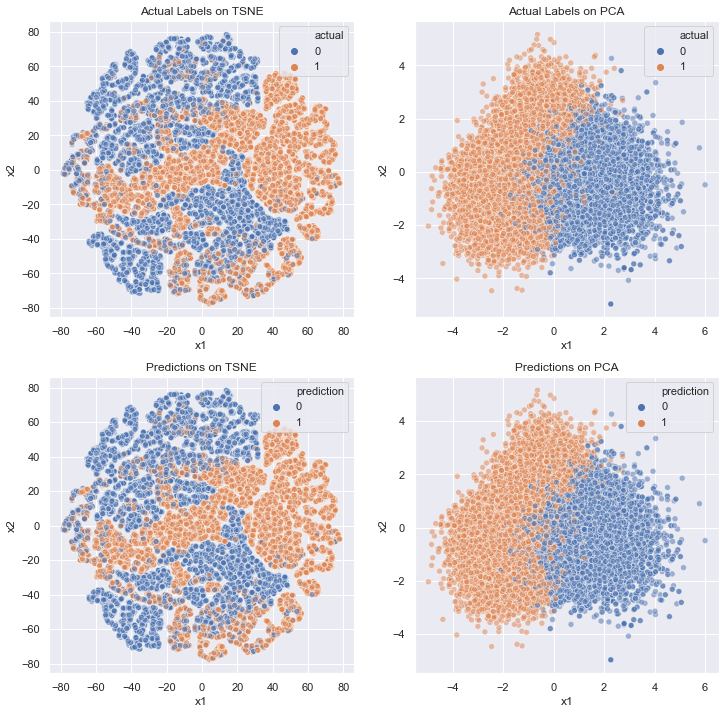

In [43]:
##Visualize the data, the top row of plots will be the actual labels
fig, ax = plt.subplots(2, 2, figsize=(12,12))
sns.scatterplot(data=PCA_df,x='x1',y='x2',hue='actual',legend="full",alpha=0.5,ax=ax[0,1])
sns.scatterplot(data=TSNE_df,x='x1',y='x2',hue='actual',legend="full",alpha=0.5,ax=ax[0,0])
sns.scatterplot(data=PCA_df,x='x1',y='x2',hue='prediction',legend="full",alpha=0.5,ax=ax[1,1])
sns.scatterplot(data=TSNE_df,x='x1',y='x2',hue='prediction',legend="full",alpha=0.5,ax=ax[1,0])
ax[0,0].set_title('Actual Labels on TSNE')
ax[0,1].set_title('Actual Labels on PCA')
ax[1,0].set_title('Predictions on TSNE')
ax[1,1].set_title('Predictions on PCA')

## Custom News Tests

Testing using the same articles that Nasir selected seems to work ok (see below).  But in more general testing (grabbing articles from various sources and social media) this model doesn't appear to scale well meaning that the dataset on which we trained is probably not very representative of the entire population of printed media that you might run into "in the wild."

In [51]:
## Testing with fake news generated from https://www.thefakenewsgenerator.com/
fakeArt = '''Flint Residents Learn To Harness Superpowers, But Trump Gets Away Again They developed superpowers 
after years of drinking from a lead-poisoned water supply. 
But just having incredible abilities doesn't make them superheroes. 
Not yet. Donald Trump faced off against the superpowered civilians but he got away before they could catch him'''

## Preprocess article
fakeArtData = pp.preprocess_string(fakeArt)

## Get article vector
fakeVec = np.array(Article_Vector(fakeArtData)).reshape((1,100))

## Get prediction and probability
## Recall, 1 = true, 0 = fake
print('Fake article has predicted label', RF.predict(fakeVec)[0],
      'with probability', RF.predict_proba(fakeVec)[0][RF.predict(fakeVec)[0]])

Fake article has predicted label 0 with probability 0.8792177808434897


In [50]:
## Testing with an article from BBC news:
bbcArt = '''Nasa Mars 2020 Mission's MiMi Aung on women in space Next year, 
Nasa will send a mission to Mars. The woman in charge of making the helicopter 
that will be sent there – which is set to become the first aircraft to fly on 
another planet – is MiMi Aung. At 16, MiMi travelled alone from Myanmar to the 
US for access to education. She is now one of the lead engineers at Nasa. We 
find out what it's like being a woman in space exploration, and why her mum is 
her biggest inspiration.'''

## Preprocess article
bbcData = pp.preprocess_string(bbcArt)

## Get article vector
bbcVec = np.array(Article_Vector(bbcData)).reshape((1,100))

## Get prediction and probability
print('BBC news article has predicted label', RF.predict(bbcVec)[0],
      'with probability', RF.predict_proba(bbcVec)[0][RF.predict(bbcVec)[0]])

BBC news article has predicted label 1 with probability 0.5586218469324882
